In [121]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

alpha = 0.05

def standardize(X):
    return (X - X.mean()) / X.std()

### Data Import & EDA

In [122]:
#https://www.geeksforgeeks.org/convert-excel-to-csv-in-python/#

data = pd.DataFrame(pd.read_csv('data.csv'))
data.head(10)

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile,CES 4.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2780,Fresno,93706,Fresno,-119.781696,36.709695,93.18,100.00,95-100% (highest scores),...,79.37,76.0,98.92,12.8,93.83,30.3,91.04,93.16,9.66,99.72
1,6077000700,4680,San Joaquin,95206,Stockton,-121.287873,37.943173,86.65,99.99,95-100% (highest scores),...,95.53,73.2,98.39,19.8,99.21,31.2,92.28,93.17,9.66,99.74
2,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,99.97,95-100% (highest scores),...,81.55,62.6,93.39,6.4,61.53,20.3,63.97,83.75,8.69,95.79
3,6019000700,3664,Fresno,93706,Fresno,-119.827707,36.734535,81.33,99.96,95-100% (highest scores),...,78.71,65.7,95.35,15.7,97.35,35.4,96.41,94.64,9.82,99.89
4,6019000200,2689,Fresno,93706,Fresno,-119.805504,36.735491,80.75,99.95,95-100% (highest scores),...,86.56,72.7,98.30,13.7,95.29,32.7,94.16,95.40,9.90,99.95
5,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,99.94,95-100% (highest scores),...,NaN,43.5,74.05,9.3,83.22,23.7,76.35,83.37,8.65,95.46
6,6019001000,4255,Fresno,93706,Fresno,-119.804314,36.697751,80.55,99.92,95-100% (highest scores),...,88.70,79.5,99.41,15.4,97.14,33.3,94.83,95.84,9.94,99.99
7,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,99.91,95-100% (highest scores),...,60.62,56.8,88.92,12.6,93.49,29.6,89.84,85.44,8.86,96.90
8,6019001202,4561,Fresno,93725,Unincorporated Fresno County area,-119.741028,36.702685,79.17,99.90,95-100% (highest scores),...,89.62,72.2,98.12,16.3,97.90,30.8,91.76,87.24,9.05,98.05
9,6077000100,3688,San Joaquin,95202,Stockton,-121.285363,37.953996,77.87,99.89,95-100% (highest scores),...,91.39,78.8,99.31,14.6,96.46,33.1,94.64,95.83,9.94,99.97


In [123]:
def fill_space(s):
    return s.replace(" ", "_").replace(".", "")

data_copy = data.copy()
for feature in data.columns:
    new_feature = fill_space(feature)
    if new_feature != feature:
        data[new_feature] = data[feature]
        data_copy[new_feature] = data_copy[feature]
        data = data.drop(columns=[feature])
        data_copy = data_copy.drop(columns=[feature])
    if 'Pctl' in feature:
        data_copy = data_copy.drop(columns=[new_feature])


data = data.drop(columns=['Education_Pctl'])
data.columns

Index(['ZIP', 'Longitude', 'Latitude', 'Ozone', 'Lead', 'Pesticides',
       'Traffic', 'Asthma', 'Education', 'Poverty', 'Unemployment',
       'Census_Tract', 'Total_Population', 'California_County',
       'Approximate_Location', 'CES_40_Score', 'CES_40_Percentile',
       'CES_40_Percentile_Range', 'Ozone_Pctl', 'PM25', 'PM25_Pctl',
       'Diesel_PM', 'Diesel_PM_Pctl', 'Drinking_Water', 'Drinking_Water_Pctl',
       'Lead_Pctl', 'Pesticides_Pctl', 'Tox_Release', 'Tox_Release_Pctl',
       'Traffic_Pctl', 'Cleanup_Sites', 'Cleanup_Sites_Pctl',
       'Groundwater_Threats', 'Groundwater_Threats_Pctl', 'Haz_Waste',
       'Haz_Waste_Pctl', 'Imp_Water_Bodies', 'Imp_Water_Bodies_Pctl',
       'Solid_Waste', 'Solid_Waste_Pctl', 'Pollution_Burden',
       'Pollution_Burden_Score', 'Pollution_Burden_Pctl', 'Asthma_Pctl',
       'Low_Birth_Weight', 'Low_Birth_Weight_Pctl', 'Cardiovascular_Disease',
       'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation',
       'Linguistic_Isolation_P

## Selecting Columns
We will focus primary on poverty level and try to find variables which we believe will correlate most with poverty level. Originally selected the following
-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty Percentile 
-   Lead
-   PM2.5 Pctl

But pivoted to the following

-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty 
-   Lead
-   PM2.5
  
The reasoning behind these choices was that if the data is already standardized it will be difficult to observed the differences between the two counties in exploration.

In [91]:
clean = data[['California_County', 'Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']].sort_values('Poverty', ascending=False)

columns = ['Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']

### Distribution of `Poverty`

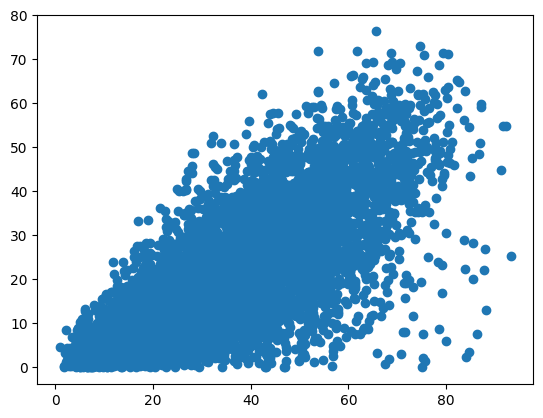

In [92]:
plt.scatter(x=clean['Poverty'],y=clean['Education'])

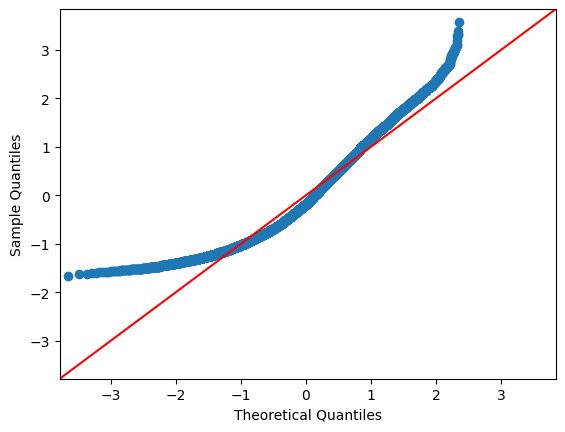

In [93]:
hide = sm.qqplot((standardize(clean['Poverty'])), stats.norm, line='45')

<AxesSubplot: xlabel='Poverty', ylabel='Count'>

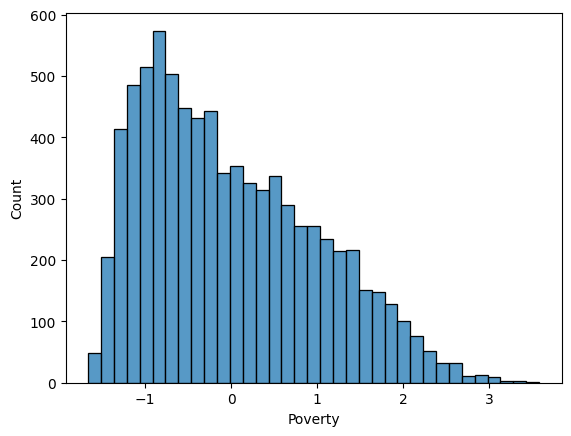

In [94]:
sns.histplot(data=standardize(data['Poverty']))

### Distribution of `Education`

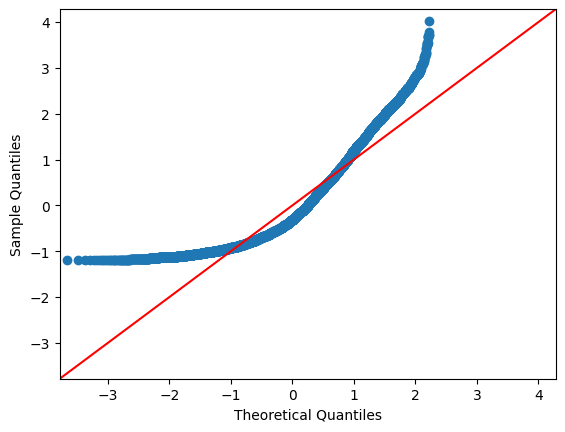

In [95]:
hide = sm.qqplot((standardize(data['Education'])), stats.norm, line='45')

<AxesSubplot: xlabel='Education', ylabel='Count'>

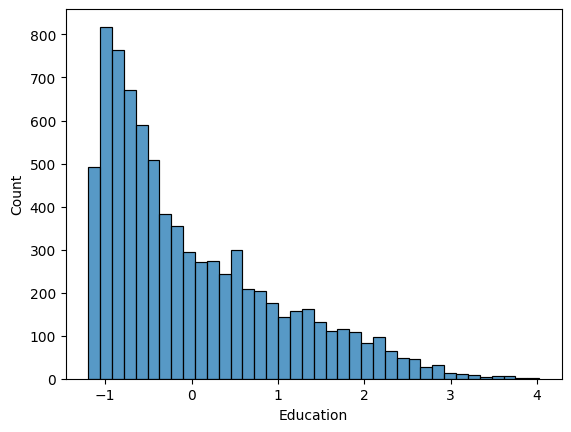

In [96]:
sns.histplot(data=standardize(data['Education']))

### Basic OLS Model

In [97]:
model_clean = smf.ols('Poverty ~ Education', clean).fit()
print(model_clean.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2554      0.198     72.054      0.000      13.868      14.643
Education      0.9787      0.009    112.583      0.000       0.962       0.996


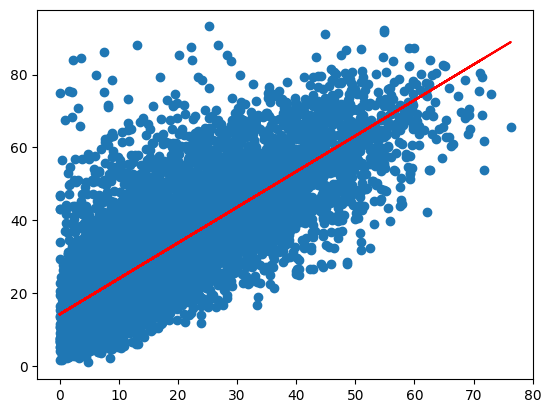

In [98]:
plt.scatter(clean['Education'], clean['Poverty'])
plt.plot(clean['Education'], model_clean.predict(clean), color='red')

Missingness?: Dropping rows where education is missing. Negligible data loss. 54 from ~2950 rows.

Five Assumptions For Lin. Regression:
1. Linear
2. Independence
3. Heteroscedasticity
4. Normally Distributed Error
5. Completeness

Our model to test:

$\hat{\text{Education}} = \text{Variables}$

The most highly correlated variables were:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Iso.: 0.71
- Poverty: 0.78
- Unemployment: 0.39
- Housing Burden: 0.53
- Cardiovascular Disease: 0.47

But to reduce multicollinearity we narrowed it down to five variables:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Isolation: 0.71
- Poverty: 0.78

In [99]:
def present(feature_x, feature_y):
    plt.scatter(x=clean[feature_x],y=clean[feature_y])

<AxesSubplot: >

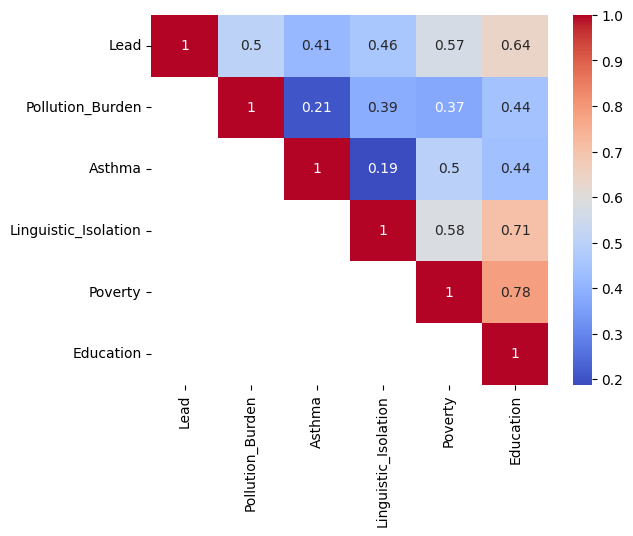

In [100]:
drop_data = data[['Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Poverty', 'Education']]
variables = drop_data.columns
corr_table = drop_data[variables].corr() 
sns.heatmap(corr_table, annot=True, cmap='coolwarm', mask=np.tril(corr_table, k=-1))

### Shapiro-Wilk Test

We can run the shapiro-wilk test to check if our data is normally distributed. The anatomy of the test is the following 
$$
\begin{aligned}
H_{0}: X_{1},X_{2},...,,X_{n} \sim N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 \\ 
H_{a}: X_{1},X_{2},...,,X_{n} \ne N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 
\end{aligned}
$$

#### Poverty Shapiro-Wilk test

In [101]:
poverty_pval = stats.shapiro(clean['Poverty']).pvalue
if poverty_pval < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

FAIL TO REJECT NULL


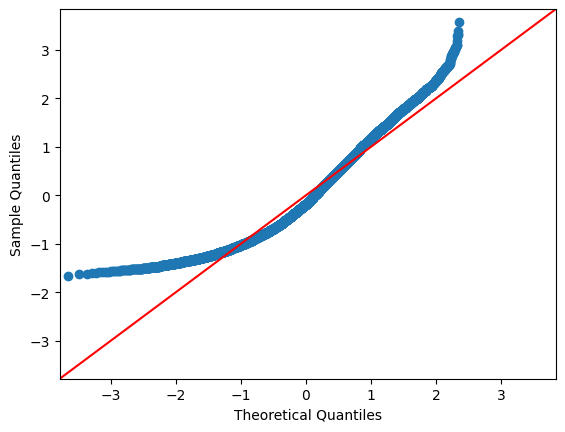

In [102]:
hide = sm.qqplot((clean['Poverty'] - clean['Poverty'].mean()) / np.std(clean['Poverty']), stats.norm, line='45')

>There seems to be evidence that the feature `Poverty` follows a normal distribution for an alpha level of .05

### Complete OLS Model

In [103]:
model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', clean).fit()

# Regression Assumptions

### Independence of residuals

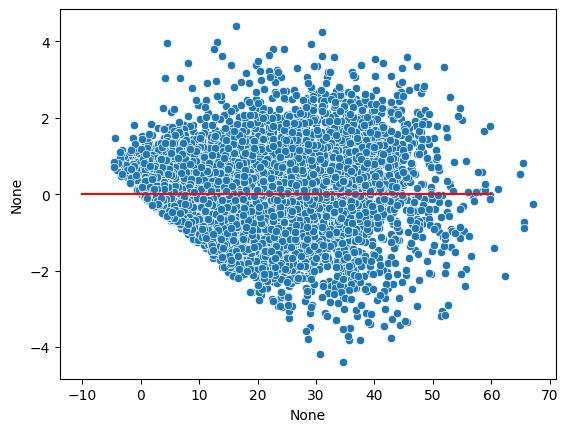

In [104]:
sns.scatterplot(x=model.fittedvalues, y=standardize(model.resid))
plt.plot(np.linspace(-10, 60, 100), np.zeros(100), 'r')

### Normality of Residuals

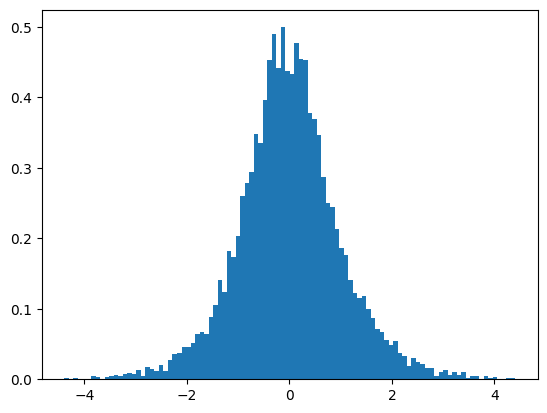

In [105]:
hide = plt.hist(standardize(model.resid), bins=100, density=True)

In [106]:
residuals_pvalue = stats.shapiro(standardize(model.resid)).pvalue
if residuals_pvalue < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

REJECT NULL


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7672.
  res = hypotest_fun_out(*samples, **kwds)


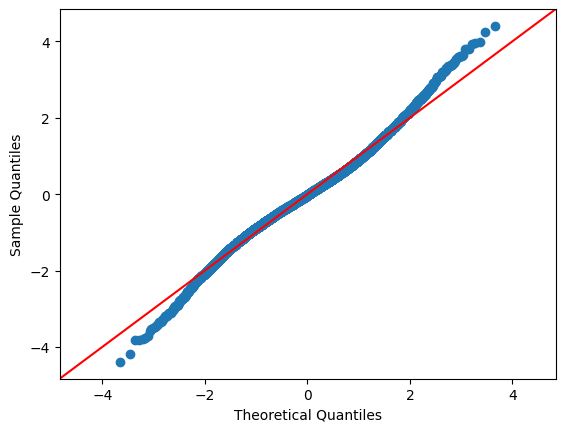

In [107]:
qq = sm.qqplot(standardize(model.resid), stats.norm, line='45')

### Check for Independence

<BarContainer object of 21 artists>

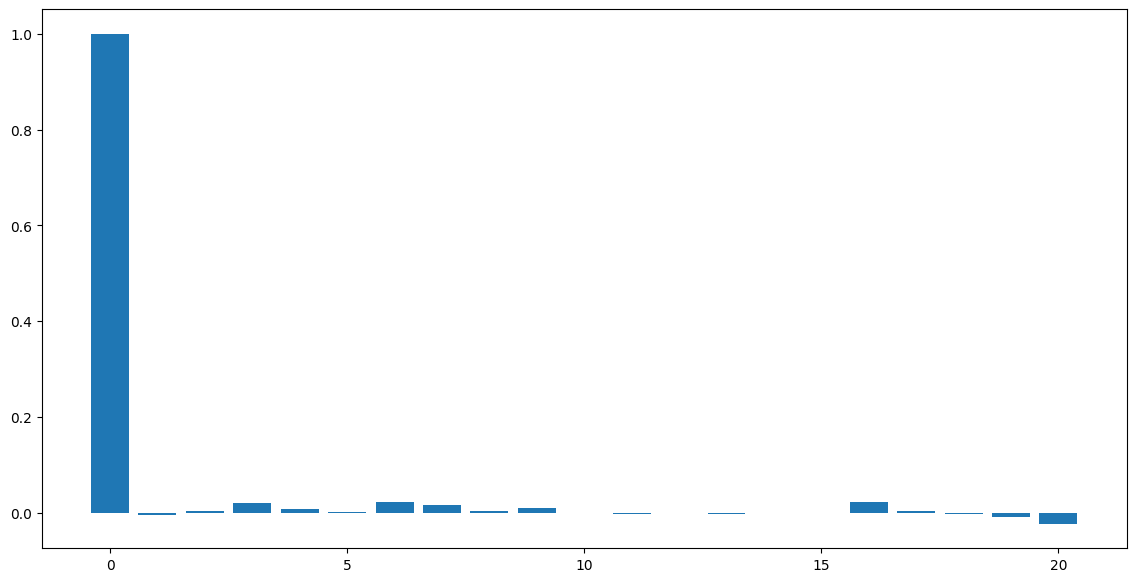

In [108]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model.resid, nlags=lags))

### Heteroscedasticity


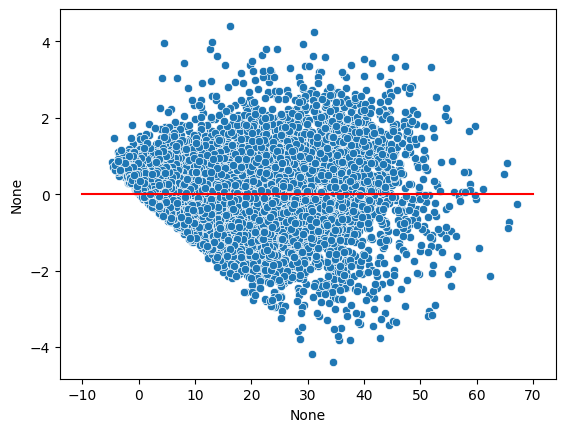

In [109]:
sns.scatterplot(x=model.predict(clean[columns]), y=standardize(model.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

### Completeness

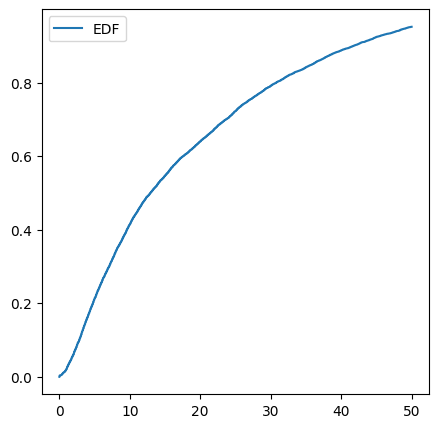

In [110]:
xrange = np.linspace(0, 50, 1000)
sd_la_ecdf= np.array([sum(clean['Education'] < x) for x in xrange]) / len(clean)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xrange, sd_la_ecdf, label='EDF')
ax.legend()

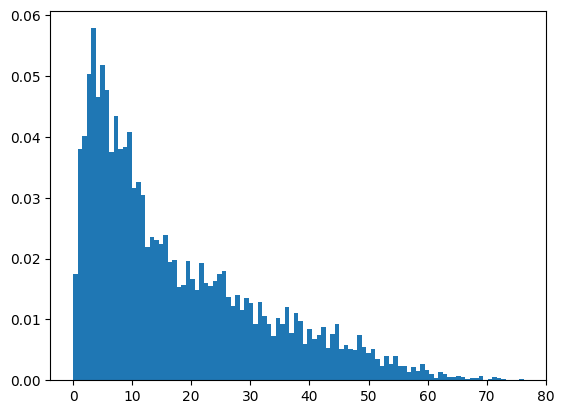

In [111]:
hide = plt.hist(clean['Education'], bins=100, density=True)

In [112]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4626.
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        21:04:04   Log-Likelihood:                -26177.
No. Observations:                7672   AIC:                         5.237e+04
Df Residuals:                    7666   BIC:                         5.241e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.3005      0.310    -26.770      0.000      -8.908      -7.693
Poverty                  0.3413      0.007     49.675      0.000       0.328       0.355
Lead                     0.1217      0.005     24.751      0.000       0.112       0.131
Asthma                   0.0363      0.003     10.932      0.000       0.030       0.043
Linguistic_Isolation     0.5308      0.011     46.255      0.000       0.508       0.553
Pollution_Burden         0.0496      0.008      6.333      0.000       0.034       0.065
==============================================================================
Omnibus:                      189.152   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.103
Skew:                           0.113   Prob(JB):                     8.86e-90
Kurtosis:                       4.110   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Feature Selection

In [118]:
criterion = lambda formula, df: smf.ols(formula, data=data).fit().bic

def add(df, selected_columns, columns, criterion, response='y'):
    best_criterion = np.inf
    best_column = None
    for column in columns - selected_columns:
        new_columns = selected_columns.union({column})
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < best_criterion:
            best_criterion = current_criterion
            best_column = column
    print(best_column)
    return selected_columns.union({best_column}), best_criterion

def forward(df, criterion, response='y'):
    selected_columns = set()
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) < len(columns):
        potential_columns, current_criterion = add(df, selected_columns, columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = potential_columns
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

forward_vars = forward(data, criterion, response='Education')
forward_vars

Poverty
Criterion: 57280.9320387672
Linguistic_Isolation
Criterion: 53485.54569503719
Unemployment_Pctl
Criterion: 52039.65421107553
CES_40_Score
Criterion: 50901.267380100784
Low_Birth_Weight
Criterion: 50332.96806617885
Pollution_Burden
Criterion: 49737.42433203601
Lead
Criterion: 49359.280023184576
Housing_Burden_Pctl
Criterion: 48847.09083903712
California_County
Criterion: 48442.36236149663
Lead_Pctl
Criterion: 48293.8614095097
Traffic_Pctl
Criterion: 48164.651724308686
Pesticides_Pctl
Criterion: 48047.25937667351
Asthma
Criterion: 47939.396036869795
Pop_Char_Score
Criterion: 47598.062834220684
Poverty_Pctl
Criterion: 47254.54952825292
Cardiovascular_Disease_Pctl
Criterion: 46693.79152929544
Asthma_Pctl
Criterion: 46224.37718929914
Low_Birth_Weight_Pctl
Criterion: 45219.29702091114
Linguistic_Isolation_Pctl
Criterion: 40402.90244407756
CES_40_Percentile_Range
Criterion: 40237.571852205176
Unemployment
Criterion: 40184.08004993615
Longitude
Criterion: 40144.88877455765
Census_Tract

{'Asthma',
 'Asthma_Pctl',
 'CES_40_Percentile_Range',
 'CES_40_Score',
 'California_County',
 'Cardiovascular_Disease_Pctl',
 'Census_Tract',
 'Housing_Burden',
 'Housing_Burden_Pctl',
 'Latitude',
 'Lead',
 'Lead_Pctl',
 'Linguistic_Isolation',
 'Linguistic_Isolation_Pctl',
 'Longitude',
 'Low_Birth_Weight',
 'Low_Birth_Weight_Pctl',
 'Pesticides_Pctl',
 'Pollution_Burden',
 'Pop_Char_Pctl',
 'Pop_Char_Score',
 'Poverty',
 'Poverty_Pctl',
 'Traffic_Pctl',
 'Unemployment',
 'Unemployment_Pctl'}

In [116]:
true_model_formula = 'Education ~ ' + ' + '.join(forward_vars)
model_forward = smf.ols(true_model_formula, data).fit()
model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1302.
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        21:07:02   Log-Likelihood:                -19614.
No. Observations:                7356   AIC:                         3.942e+04
Df Residuals:                    7260   BIC:                         4.008e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -9564.4071   2118.479     -4.515      0.000   -1.37e+04   -5411.572
California_County[T.Alpine ]                         2.931e-05   6.66e-06      4.402      0.000    1.63e-05    4.24e-05
California_County[T.Amador ]                           -1.6525      1.749     -0.945      0.345      -5.082       1.777
California_County[T.Butte ]                            -7.0568      2.117     -3.333      0.001     -11.208      -2.906
California_County[T.Calaveras ]                       -10.7794      2.972     -3.626      0.000     -16.606      -4.953
California_County[T.Colusa ]                          -12.1285      3.745     -3.238      0.001     -19.470      -4.787
California_County[T.Contra Costa]                     -17.4441      4.208     -4.145      0.000     -25.694      -9.194
California_County[T.Del Norte]                       1.353e-12   5.31e-13      2.547      0.011    3.12e-13    2.39e-12
California_County[T.El Dorado]                        -20.6551      5.519     -3.743      0.000     -31.474      -9.837
California_County[T.Fresno ]                          -24.6612      6.167     -3.999      0.000     -36.750     -12.573
California_County[T.Glenn ]                           -28.3025      7.103     -3.985      0.000     -42.227     -14.378
California_County[T.Humboldt ]                        -34.2310      7.737     -4.424      0.000     -49.398     -19.064
California_County[T.Imperial ]                        -35.0480      8.355     -4.195      0.000     -51.426     -18.670
California_County[T.Inyo ]                            -35.7261      9.114     -3.920      0.000     -53.592     -17.860
California_County[T.Kern ]                            -41.0521      9.671     -4.245      0.000     -60.010     -22.094
California_County[T.Kings ]                           -45.1759     10.397     -4.345      0.000     -65.557     -24.795
California_County[T.Lake ]                            -50.3950     11.182     -4.507      0.000     -72.316     -28.474
California_County[T.Lassen ]                          -44.9429     11.955     -3.759      0.000     -68.378     -21.508
California_County[T.Los Angeles]                      -55.4651     12.643     -4.387      0.000     -80.249     -30.682
California_County[T.Madera ]                          -54.7028     13.215     -4.140      0.000     -80.607     -28.798
California_County[T.Marin ]                           -62.2156     14.012     -4.440      0.000     -89.684     -34.748
California_County[T.Mariposa ]                        -63.5646     14.673     -4.332      0.000     -92.327     -34.802
California_County[T.Mendocino ]                       -69.5633     15.420     -4.51

### Forward Selection Model Analysis

#### Linearity

<BarContainer object of 21 artists>

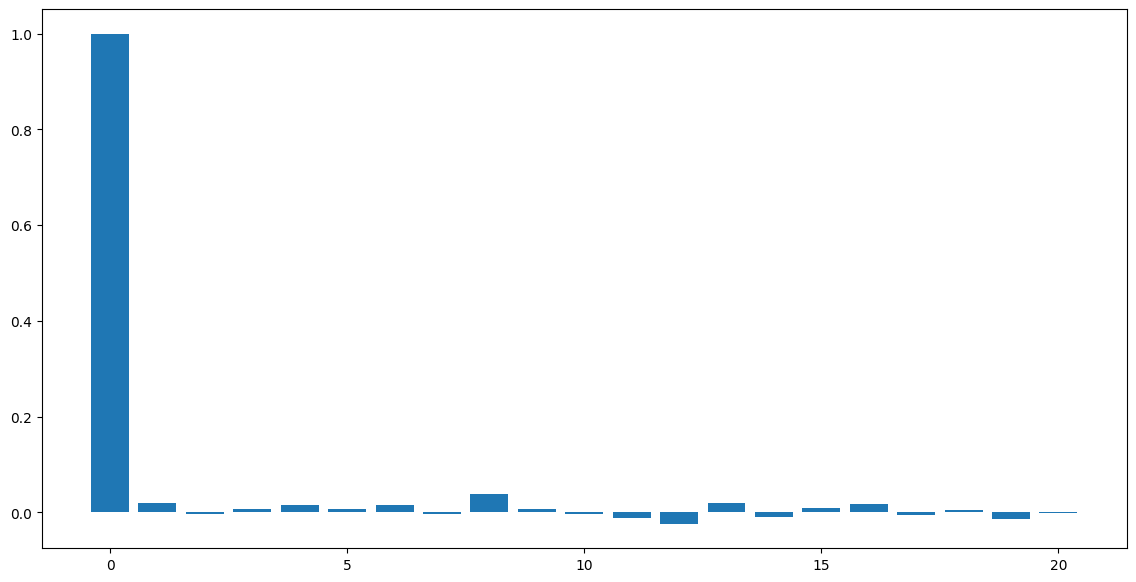

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_forward.resid, nlags=lags))

#### Independence of residuals

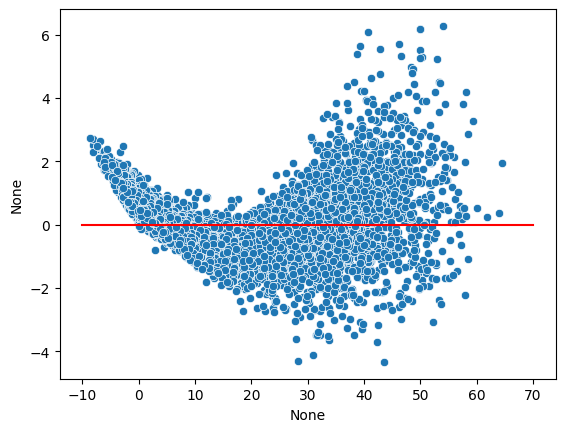

In [88]:
sns.scatterplot(x=model_forward.predict(data), y=standardize(model_forward.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

In [124]:
forward_vars_cleaned = forward(data_copy, criterion, response='Education')
forward_vars_cleaned

Poverty
Criterion: 57280.9320387672
Linguistic_Isolation
Criterion: 53485.54569503719
Unemployment
Criterion: 52041.31879448832
CES_40_Score
Criterion: 50885.14943420967
Low_Birth_Weight
Criterion: 50320.770162607914
Pollution_Burden
Criterion: 49726.490642077966
Housing_Burden
Criterion: 49350.36675268524
Lead
Criterion: 48868.60357022404
California_County
Criterion: 48503.991961845386
Traffic
Criterion: 48384.094093312124
Asthma
Criterion: 48285.88052833552
Pop_Char_Score
Criterion: 48107.478212581176
CES_40_Percentile_Range
Criterion: 47856.7246812195
Cardiovascular_Disease
Criterion: 47775.95745822264
Total_Population
Criterion: 47737.859111156315
Census_Tract
Criterion: 47709.904543018114
Diesel_PM
Criterion: 47685.57372268011
Pesticides
Criterion: 47664.18914201987
Longitude
Criterion: 47657.92137727838
Solid_Waste
Criterion: 47653.18457575813
Groundwater_Threats
Criterion: 47648.522251507384
Drinking_Water
Criterion: 47646.46234713656
CES_40_Percentile


{'Asthma',
 'CES_40_Percentile_Range',
 'CES_40_Score',
 'California_County',
 'Cardiovascular_Disease',
 'Census_Tract',
 'Diesel_PM',
 'Drinking_Water',
 'Groundwater_Threats',
 'Housing_Burden',
 'Lead',
 'Linguistic_Isolation',
 'Longitude',
 'Low_Birth_Weight',
 'Pesticides',
 'Pollution_Burden',
 'Pop_Char_Score',
 'Poverty',
 'Solid_Waste',
 'Total_Population',
 'Traffic',
 'Unemployment'}

In [126]:
forward_vars_cleaned = forward_vars_cleaned - {'CES_40_Score', 'CES_40_Percentile_Range'}
true_model_formula = 'Education ~ ' + ' + '.join(forward_vars_cleaned)
model_forward_cleaned = smf.ols(true_model_formula, data_copy).fit()
model_forward_cleaned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     474.5
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        21:19:49   Log-Likelihood:                -23897.
No. Observations:                7355   AIC:                         4.794e+04
Df Residuals:                    7283   BIC:                         4.843e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -2.217e+04   3981.742     -5.568      0.000      -3e+04   -1.44e+04
California_County[T.Alpine ]          5.816e-05   1.07e-05      5.456      0.000    3.73e-05    7.91e-05
California_County[T.Amador ]            -9.4139      3.222     -2.922      0.003     -15.729      -3.099
California_County[T.Butte ]            -23.1540      3.839     -6.032      0.000     -30.679     -15.629
California_County[T.Calaveras ]        -25.8253      5.564     -4.641      0.000     -36.733     -14.918
California_County[T.Colusa ]           -31.7987      6.953     -4.573      0.000     -45.429     -18.169
California_County[T.Contra Costa]      -41.6402      7.915     -5.261      0.000     -57.156     -26.125
California_County[T.Del Norte]       -4.878e-10   9.07e-11     -5.376      0.000   -6.66e-10    -3.1e-10
California_County[T.El Dorado]         -50.5165     10.367     -4.873      0.000     -70.839     -30.194
California_County[T.Fresno ]           -57.6260     11.697     -4.927      0.000     -80.555     -34.697
California_County[T.Glenn ]            -71.9524     13.308     -5.407      0.000     -98.040     -45.865
California_County[T.Humboldt ]         -90.5444     14.444     -6.269      0.000    -118.858     -62.231
California_County[T.Imperial ]         -76.8147     15.654     -4.907      0.000    -107.502     -46.128
California_County[T.Inyo ]             -87.9314     17.159     -5.125      0.000    -121.568     -54.295
California_County[T.Kern ]             -93.9928     18.275     -5.143      0.000    -129.817     -58.168
California_County[T.Kings ]           -105.8268     19.617     -5.395      0.000    -144.282     -67.371
California_County[T.Lake ]            -117.1629     21.068     -5.561      0.000    -158.462     -75.863
California_County[T.Lassen ]          -119.0155     22.406     -5.312      0.000    -162.937     -75.093
California_County[T.Los Angeles]      -124.6448     23.828     -5.231      0.000    -171.354     -77.936
California_County[T.Madera ]          -129.2627     24.936     -5.184      0.000    -178.144     -80.381
California_County[T.Marin ]           -143.2887     26.345     -5.439      0.000    -194.933     -91.645
California_County[T.Mariposa ]        -152.6144     27.650     -5.520      0.000    -206.816     -98.413
California_County[T.Mendocino ]       -163.6406     28.979     -5.647      0.000    -220.447    -106.834
California_County[T.Merced ]          -160.7388     30.240     -5.316      0.000    -220.017    -101.460
California_County[T.Modoc ]          -1.642e-12   3.05e-13     -5.376      0.000   -2.24e-12   -1.04e-12
California_County[T.Mono ]            3.614e-13   6.28e-14      5.759      0.000    2.38e-13    4.84e-13
California_County[T.Monterey ]        